<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Producing-random-input" data-toc-modified-id="Producing-random-input-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Producing random input</a></span></li></ul></li></ul></div>

# Preamble

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

from network import Protocol, NetworkManager, Network
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities, calculate_triad_connectivity
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

In [2]:
epsilon = 10e-80
vmin = -3.0
remove = 0.010

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 2.0
g_a = 2.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

## Producing random input

In [105]:
sigma_out = 0.00
tau_z_pre = 0.025
tau_z_post = 0.005
g_a = 2.0

hypercolumns = 1
minicolumns = 100
n_patterns = 500

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.00
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0
resting_time = 0.0
epochs = 1
T_persistence = 0.100

# Manager properties
values_to_save = ['s', 'o', 'w', 'z_pre', 'beta', 'p_post', 'p_pre', 'P']


# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the representation
activity = np.random.randint(0, minicolumns, n_patterns)[:, np.newaxis]
#activity = np.array([0, 1, 2, 3, 4])[:, np.newaxis]
representation = PatternsRepresentation(activity, minicolumns=minicolumns)


# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
manager.run_network_protocol(protocol=protocol, plasticity_on=False)

../network.py:349: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pattern == epoch_end_string:
../connectivity_functions.py:15: RuntimeWarning: divide by zero encountered in true_divide
  x = P / outer
../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


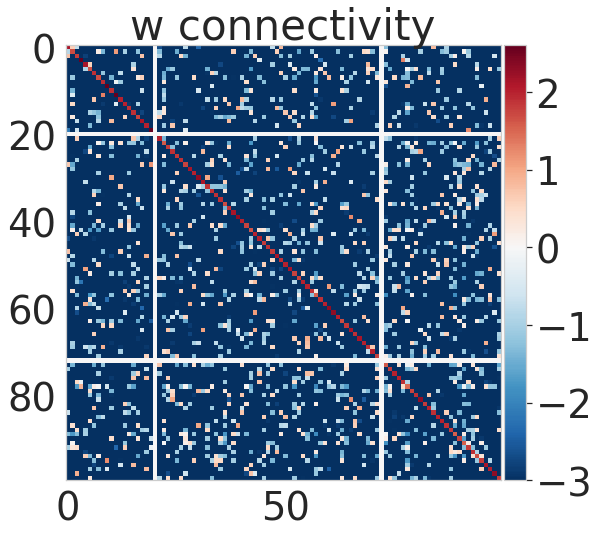

In [106]:
plot_weight_matrix(manager, vmin=vmin)

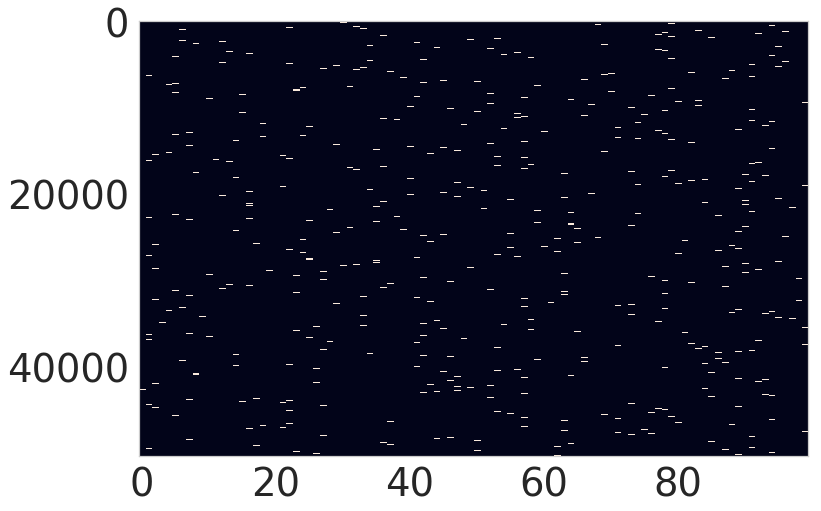

In [107]:
plt.imshow(manager.history['o'], aspect='auto')

../network.py:506: RuntimeWarning: invalid value encountered in log
  self.T = self.nn.tau_a * np.log(1 / (1 - self.B))
../network.py:510: RuntimeWarning: invalid value encountered in less
  self.T[self.T < 0] = 0.0


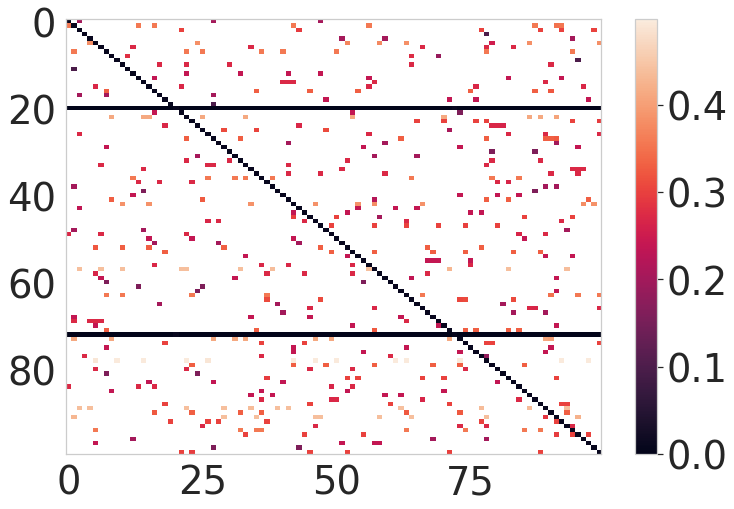

In [108]:
manager.calculate_persistence_time_matrix()
T = manager.T
B = manager.B
B[B > 1.0] = 0.0
plt.imshow(T.T, aspect='auto')
plt.colorbar()

In [110]:
start = 0
keep = True
index = 0
B_for_exploring = T + np.diag(10 * np.ones(minicolumns))
sequence_from = [start]
for i in range(11):
    print('start', start)
    B_column = B_for_exploring[:, start]
    next_one = np.nanargmin(B_column)
    sequence_from.append(next_one)
    start = next_one
    print(sequence_from)

start 0
[0, 2]
start 2
[0, 2, 43]
start 43
[0, 2, 43, 2]
start 2
[0, 2, 43, 2, 43]
start 43
[0, 2, 43, 2, 43, 2]
start 2
[0, 2, 43, 2, 43, 2, 43]
start 43
[0, 2, 43, 2, 43, 2, 43, 2]
start 2
[0, 2, 43, 2, 43, 2, 43, 2, 43]
start 43
[0, 2, 43, 2, 43, 2, 43, 2, 43, 2]
start 2
[0, 2, 43, 2, 43, 2, 43, 2, 43, 2, 43]
start 43
[0, 2, 43, 2, 43, 2, 43, 2, 43, 2, 43, 2]


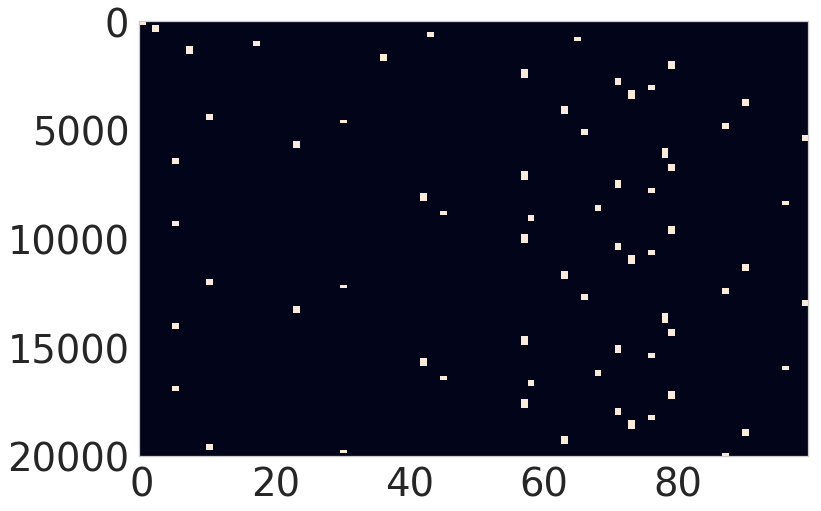

In [111]:
start = 0
I_cue = np.zeros(minicolumns)
I_cue[start] = 1.0
manager.run_network_recall(I_cue=I_cue, T_recall=20.0, T_cue=tau_s)
plt.imshow(manager.history['o'], aspect='auto')

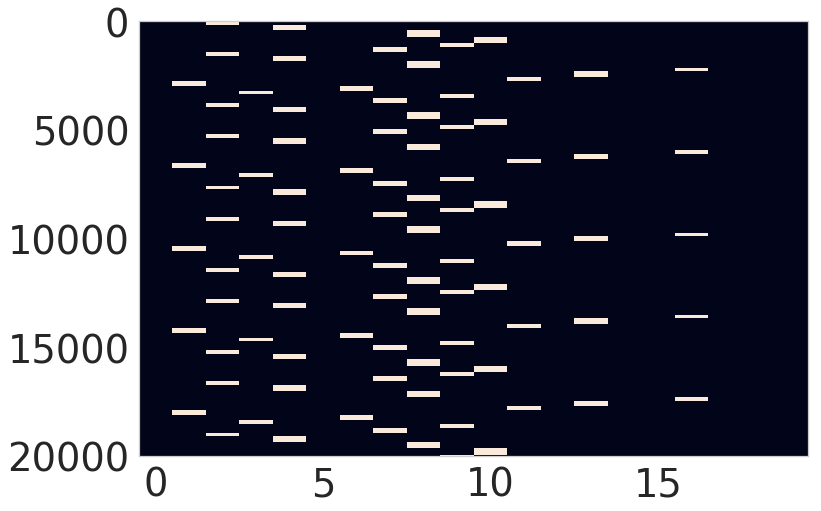

In [104]:
start = 2
I_cue = np.zeros(minicolumns)
I_cue[start] = 1.0
manager.run_network_recall(I_cue=I_cue, T_recall=20.0, T_cue=tau_s)
plt.imshow(manager.history['o'], aspect='auto')

/home/heberto/miniconda/envs/py37/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


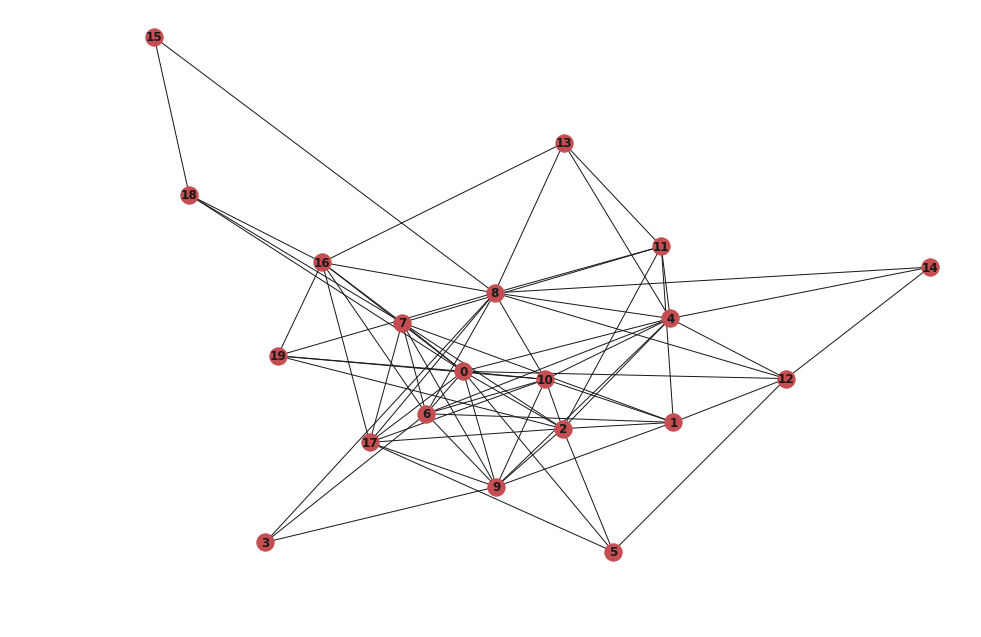

In [61]:
import networkx as nx

G_b = nx.from_numpy_matrix(B)


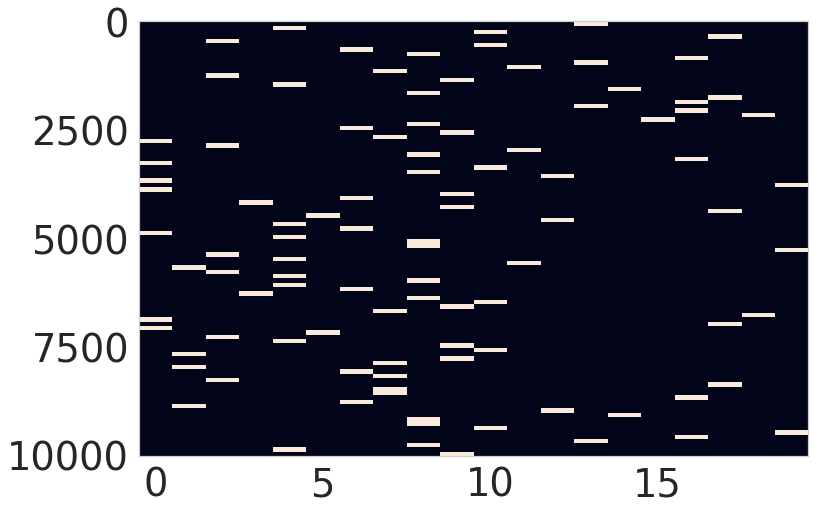

In [48]:
protocol.patterns_sequence

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 